In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext rpy2.ipython

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.sparse as sps
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals

from ampute import ampute_mcar, ampute_mar
from coclust_mod_impute import (CoclustModImpute,
                                summarize_blocks, get_block_counts,
                                _impute_block_representative)
from utils import show_matrix
import joblib
import os # to play sound at the end of the execution

In [151]:
np.set_printoptions(precision=3)

In [4]:
%%R
# library(mice)
library(missMDA)
library(FactoMineR)

In [5]:
repartition = pd.read_csv('data/repartition.csv')
repartition.describe()
repartition.head()

,HF00,HF05,HF10,HF15,HF20,HF25,HF30,HF35,HF40,HF45,HF50,HF55,HF60,HF65,HF70,HF75,HF80,Total
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.275909,0.286364,0.296818,0.305455,0.290455,0.328636,0.333182,0.335455,0.328182,0.328182,0.292273,0.211364,0.212273,0.211818,0.189545,0.155909,0.164091,4.544091
std,0.260707,0.255539,0.248814,0.251580,0.263718,0.319826,0.316113,0.302289,0.277465,0.276692,0.256755,0.181929,0.153714,0.143149,0.124651,0.101309,0.115538,3.822070
min,0.020000,0.030000,0.030000,0.030000,0.020000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.020000,0.020000,0.020000,0.020000,0.020000,0.440000
25%,0.150000,0.152500,0.170000,0.172500,0.152500,0.172500,0.175000,0.175000,0.185000,0.177500,0.155000,0.115000,0.122500,0.122500,0.110000,0.090000,0.090000,2.510000
50%,0.215000,0.225000,0.240000,0.240000,0.220000,0.245000,0.250000,0.260000,0.250000,0.260000,0.220000,0.160000,0.170000,0.175000,0.155000,0.120000,0.125000,3.545000
75%,0.282500,0.295000,0.315000,0.332500,0.315000,0.337500,0.340000,0.360000,0.357500,0.365000,0.325000,0.235000,0.257500,0.260000,0.240000,0.190000,0.197500,4.970000
max,1.270000,1.240000,1.200000,1.210000,1.290000,1.590000,1.560000,1.490000,1.370000,1.370000,1.260000,0.880000,0.740000,0.670000,0.570000,0.460000,0.540000,18.710000


,Regions,HF00,HF05,HF10,HF15,HF20,HF25,HF30,HF35,HF40,HF45,HF50,HF55,HF60,HF65,HF70,HF75,HF80,Total
0,ILEF,1.27,1.24,1.20,1.21,1.29,1.59,1.56,1.49,1.37,1.37,1.26,0.88,0.74,0.67,0.57,0.46,0.54,18.71
1,CHAM,0.14,0.15,0.16,0.16,0.15,0.17,0.16,0.17,0.17,0.17,0.15,0.10,0.11,0.10,0.09,0.08,0.08,2.29
2,PICA,0.21,0.22,0.24,0.23,0.20,0.23,0.23,0.24,0.23,0.24,0.20,0.13,0.14,0.14,0.12,0.10,0.09,3.17
3,HNOR,0.19,0.21,0.22,0.22,0.19,0.22,0.22,0.22,0.23,0.22,0.19,0.13,0.13,0.13,0.11,0.09,0.10,3.04
4,CENT,0.24,0.26,0.27,0.27,0.24,0.29,0.29,0.30,0.30,0.31,0.27,0.19,0.21,0.21,0.19,0.16,0.18,4.17


In [6]:
X = np.array([
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]])
X = X[np.ix_([0, 2, 7, 1, 4, 8, 3, 5, 6],
             [ 0,  4,  5, 15,  8,  9, 12, 13,  7, 10,  1,  2,  3,  6, 11, 14])]

n_clusters = 3
w = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2])
z = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

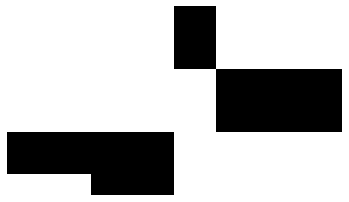

In [7]:
show_matrix(X)

In [8]:
res, r_nan, c_nan = ampute_mcar(X, .1)
print(np.isnan(res).sum())
print(res)

14
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0. nan  0.  0.  0.]
 [ 0.  0. nan nan  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. nan  0.  0.  0.  0. nan  0.  1.  1.  1.  1.  1.  1.]
 [ 0. nan nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 0.  0. nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 1. nan  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1. nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [9]:
def shrink_ca(X, ncp=2):
    n, p = X.shape
    N = X.sum()
    P = X / N
    Rc = P.sum(axis=0)[np.newaxis, :]
    Rr = P.sum(axis=1)[:, np.newaxis]
    
    S = (P - Rr @ Rc) / Rr**.5 / Rc**.5
    u, s, v = np.linalg.svd(S, full_matrices=True)

    sigma2 = (s[ncp:]**2).sum() / ((n-1)*(p-1) - (n-1)*ncp - (p-1)*ncp + ncp**2)
    lambda_shrunk = (s[:ncp]**2 - n * p / min(p,n-1) * sigma2) / s[:ncp]
    
    if ncp == 1:
        recon = (u[:,0] * lambda_shrunk)[:,np.newaxis] @ v[0,:][np.newaxis,:]
    else:
        recon = (u[:,:ncp] * lambda_shrunk) @ v[:ncp,]
    
    recon = N * (((recon * Rr**.5) * Rc**.5) + Rr @ Rc)
    return recon

rec = shrink_ca(X, ncp=3)
np.allclose(X, rec)
np.sum((X - rec)**2)

True

4.934560527463752e-30

In [169]:
def shrink_ca2(X, ncp=2):
    n, p = X.shape
    N = X.sum()
    N = 1 if N == 0 else N
    P = X / N
    Rc = P.sum(axis=0)[np.newaxis, :]
    Rr = P.sum(axis=1)[:, np.newaxis]
    Rc[Rc==0] = 1
    Rr[Rr==0] = 1
    S = (P - Rr @ Rc) / Rr**.5 / Rc**.5
    
#     print(X)
#     print(S)

    svals = svdvals(S)
    u, s, v = sps.linalg.svds(S, k=ncp)
#     print(s)
#     print(svals)
    zero_vals = np.isclose(0, s) # find which singular values are null
    den = ((n-1)*(p-1) - (n-1)*ncp - (p-1)*ncp + ncp**2)
    sigma2 = (svals[ncp:]**2).sum() / (1 if den == 0 else den)
#     print('sigma2', sigma2)
    lambda_shrunk = s.copy()
#     print(s[~zero_vals])
#     print(lambda_shrunk)
    lambda_shrunk[~zero_vals] = (s[~zero_vals]**2 - n * p / min(p,n-1) * sigma2) / s[~zero_vals]
#     print(lambda_shrunk)
    
    recon = (u * lambda_shrunk) @ v
    recon = N * (((recon * Rr**.5) * Rc**.5) + Rr @ Rc)
    recon[recon < 0] = 0 # account for numerical errors and avoid negative values
    
    return recon

# shrink_ca2(np.array([[0, 0, 0, 0, 0, 0, 0, 0],
#                      [0, 0, 0, 0, 0, 0, 0, 0],
#                      [0, 0, 0, 0, 0, 0, 0, 0]]))
rec = shrink_ca2(X, ncp=3)
# print(rec)
print(rec.shape)
np.allclose(X, rec)
np.sum((X - rec)**2)

(9, 16)


True

1.438176148909016e-30

In [170]:
def impute_block_ca2(X, Z, W, z, w, r_nan, c_nan, ncp=2):
    z = z.ravel()
    w = w.ravel()
    zvals = np.unique(z)
    wvals = np.unique(w)
    
    for zval in zvals:
        for wval in wvals:
            block_z = z==zval
            block_w = w==wval
                           
            pois = (z[r_nan] == zval) & (w[c_nan] == wval)
            
            X_2_B_r = np.ones(z.shape[0], dtype=int)*-1
            X_2_B_c = np.ones(w.shape[0], dtype=int)*-1

            if np.any(pois):
#                 print(f'block {zval,wval} has nans')
                block = X[np.ix_(block_z,block_w)]
                min_dim = min(block.shape)
                if min_dim < 2:
                    summary = block.sum() / block.size
                    X[r_nan[pois], c_nan[pois]] = summary
                else:
                    recon = shrink_ca2(block, min(ncp, min_dim-1))

                    X_2_B_r[block_z] = np.arange(block.shape[0])
                    X_2_B_c[block_w] = np.arange(block.shape[1])

                    X[r_nan[pois], c_nan[pois]] = recon[X_2_B_r[r_nan[pois]], X_2_B_c[c_nan[pois]]]

    return X

X_missing, r_nan, c_nan = ampute_mcar(X, .2)

# sps.csr_matrix((np.ones(r_nan.shape),(r_nan, c_nan)))

# print(r_nan)
# print(c_nan)
# print(X_missing[r_nan, c_nan])
print(X_missing.T)
# res = impute_block_ca2(X.astype(float), None, None, z, w, r_nan, c_nan)
# print(np.round(res.T, 2))
model2 = (CoclustModImpute(n_clusters=n_clusters, n_init=10)
          .fit(X_missing, impute_block_ca2, initial_vals=None, ))
impute2 = model2.X_
print(np.round(impute2.T,2))
print(X.T)

[[ 0.  0.  0.  0. nan  0.  1.  1.  0.]
 [ 0.  0.  0.  0. nan  0. nan nan  0.]
 [ 0. nan  0.  0. nan nan  1.  1.  0.]
 [ 0. nan  0. nan  0.  0.  1.  1.  0.]
 [nan  0.  0.  0.  0.  0. nan  1. nan]
 [ 0.  0.  0.  0. nan  0.  1. nan nan]
 [ 0.  0.  0.  0.  0.  0.  1.  1.  1.]
 [ 0.  0.  0. nan  0.  0.  1. nan  1.]
 [ 1.  1.  1. nan  0.  0.  0.  0.  0.]
 [nan  1.  1.  0. nan  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  0.  0.  0.]
 [nan nan  0.  1.  1.  1.  0.  0.  0.]
 [nan  0.  0.  1.  1.  1.  0.  0.  0.]
 [ 0.  0. nan  1.  1.  1.  0. nan  0.]
 [ 0.  0.  0.  1. nan nan nan  0.  0.]
 [ 0.  0.  0.  1.  1.  1.  0.  0.  0.]]
[[0.   0.   0.   0.   0.   0.   1.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.31 0.31 0.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.01]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.01]
 [0.   0.   0.   0.   0.   0.   1.   1.   1.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.

In [167]:
diff = np.abs(X-model2.X_)
print(f"RMSE: {((diff**2).sum()/r_nan.shape[0])**.5}")

RMSE: 0.3226004508412721
